# Simulation

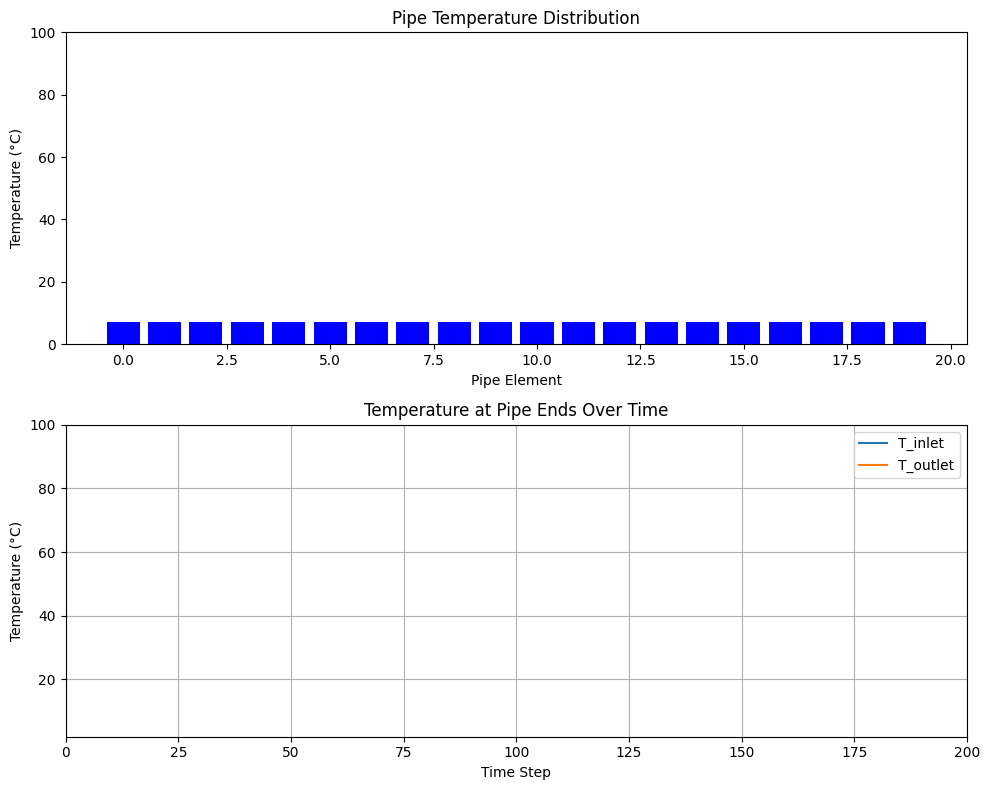

Output()

In [4]:
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import ipywidgets as widgets
from IPython.display import display, clear_output
import time

# -----------------------------
# Pipe simulation functions
# -----------------------------
def propagate_pipe(pipe_temperature: list[float]):
    T_end = pipe_temperature.pop(-1)
    pipe_temperature.insert(0, T_end)

def update_pipe(pipe_temperature, loss_coeff, T_ext, T_heater, heat_coeff):
    N = len(pipe_temperature)
    new_temperatures = pipe_temperature.copy()
    for i in range(1, N - 1):
        new_temperatures[i] = (
            pipe_temperature[i - 1]
            + pipe_temperature[i]
            + loss_coeff * T_ext
        ) / (2.0 + loss_coeff)
    new_temperatures[0] = (heat_coeff * T_heater + pipe_temperature[0]) / (heat_coeff + 1)
    return new_temperatures

# -----------------------------
# Live plotting setup
# -----------------------------
class PipeSimulator:
    def __init__(self, T_ext=7, N=20):
        self.T_ext = T_ext
        self.N = N
        self.T_heater = 120
        self.t_max = 200
        self.loss_coeff = 2e-2
        self.heat_coeff = 0.5
        self.pipe_temperature = [T_ext] * N
        self.times, self.T_start_history, self.T_end_history = [], [], []

        # Setup figure
        self.fig, (self.ax1, self.ax2) = plt.subplots(2, 1, figsize=(10, 8))
        self.bar_container = self.ax1.bar(range(self.N), self.pipe_temperature, color="blue")
        self.ax1.set_ylim(0, 100)
        self.ax1.set_title("Pipe Temperature Distribution")
        self.ax1.set_xlabel("Pipe Element")
        self.ax1.set_ylabel("Temperature (°C)")

        self.norm = Normalize(vmin=0, vmax=100)

        # Line plots for pipe ends
        self.line_start, = self.ax2.plot([], [], label="T_inlet")
        self.line_end, = self.ax2.plot([], [], label="T_outlet")
        self.ax2.set_xlim(0, self.t_max)
        self.ax2.set_ylim(self.T_ext - 5, 100)
        self.ax2.set_title("Temperature at Pipe Ends Over Time")
        self.ax2.set_xlabel("Time Step")
        self.ax2.set_ylabel("Temperature (°C)")
        self.ax2.grid()
        self.ax2.legend()
        plt.tight_layout()
        plt.ion()
        plt.show()

    def step(self):
        # Update temperatures
        self.pipe_temperature = update_pipe(self.pipe_temperature, self.loss_coeff, self.T_ext, self.T_heater, self.heat_coeff)
        propagate_pipe(self.pipe_temperature)

        # Update bar plot
        for bar, temp in zip(self.bar_container, self.pipe_temperature):
            bar.set_height(temp)
            bar.set_color(plt.cm.jet(self.norm(temp)))

        # Update line plots
        t = len(self.times)
        self.times.append(t)
        self.T_start_history.append(self.pipe_temperature[2])
        self.T_end_history.append(self.pipe_temperature[0])
        self.line_start.set_data(self.times, self.T_start_history)
        self.line_end.set_data(self.times, self.T_end_history)

        # Adjust x-axis
        if t >= self.ax2.get_xlim()[1]:
            self.ax2.set_xlim(0, t + self.t_max * 0.1)

        self.fig.canvas.draw()
        self.fig.canvas.flush_events()

    def reset(self, T_ext, N):
        self.T_ext = T_ext
        self.N = N
        self.pipe_temperature = [T_ext] * N
        self.times, self.T_start_history, self.T_end_history = [], [], []

        # Reset bar plot
        self.ax1.cla()
        self.ax1.set_ylim(0, 100)
        self.ax1.set_title("Pipe Temperature Distribution")
        self.ax1.set_xlabel("Pipe Element")
        self.ax1.set_ylabel("Temperature (°C)")
        self.bar_container = self.ax1.bar(range(self.N), self.pipe_temperature, color="blue")
        self.norm = Normalize(vmin=0, vmax=100)

        # Reset line plots
        self.ax2.cla()
        self.line_start, = self.ax2.plot([], [], label="T_inlet")
        self.line_end, = self.ax2.plot([], [], label="T_outlet")
        self.ax2.set_xlim(0, self.t_max)
        self.ax2.set_ylim(self.T_ext - 5, 100)
        self.ax2.set_title("Temperature at Pipe Ends Over Time")
        self.ax2.set_xlabel("Time Step")
        self.ax2.set_ylabel("Temperature (°C)")
        self.ax2.grid()
        self.ax2.legend()
        plt.tight_layout()
        self.fig.canvas.draw()
        self.fig.canvas.flush_events()


# -----------------------------
# Interactive widgets
# -----------------------------
sim = PipeSimulator()

def update_simulation(T_ext, N):
    sim.reset(T_ext, N)

T_ext_slider = widgets.IntSlider(value=7, min=0, max=50, step=1, description='T_ext:')
N_slider = widgets.IntSlider(value=20, min=5, max=50, step=1, description='N:')

ui = widgets.VBox([T_ext_slider, N_slider])
out = widgets.interactive_output(update_simulation, {'T_ext': T_ext_slider, 'N': N_slider})
display(ui, out)

# Run the simulation continuously
import threading

def run_loop():
    while True:
        sim.step()
        time.sleep(0.1)  # adjust speed here

thread = threading.Thread(target=run_loop, daemon=True)
thread.start()
